# Testing Img Clustering with EfficientNetB3

In [2]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import tensorflow as tf
from tensorflow.keras.applications.efficientnet import EfficientNetB3
from tensorflow.keras.applications import EfficientNetB3
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from sklearn.cluster import KMeans
from tensorflow.keras.applications.efficientnet import EfficientNetB3, preprocess_input
import zipfile
import os
import numpy as np

2024-03-05 16:08:42.566662: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [5]:
import tensorflow as tf
print(tf.__version__)

2.15.0


In [4]:
channels = ['ERSyto', 'ERSytoBleed', 'Hoechst', 'Mito', 'Ph_golgi']
base_dir = '../raw_data/plate_24277'
extracted_channels = {}

In [14]:
# Step 1: Extract and load images from all channels
# For simplicity, I'm just writing pseudo-code for these steps

channels = ['ERSyto', 'ERSytoBleed', 'Hoechst', 'Mito', 'Ph_golgi']
base_dir = '../raw_data/plate_24277'
extracted_channels = {}

# Verify that the base directory exists
if not os.path.exists(base_dir):
    print(f"The specified base directory does not exist: {base_dir}")
else:
    # Loop through each channel and process the zip files
    for channel in channels:
        # The zip_path is corrected by removing the redundant 'plate_24277' segment
        zip_path = os.path.join(base_dir, f'24277-{channel}.zip')
        
        # Check if the zip file exists
        if os.path.isfile(zip_path):
            with zipfile.ZipFile(zip_path, 'r') as zip_ref:
                # Create a directory for the extracted files
                channel_dir = os.path.join(base_dir, channel)
                if not os.path.exists(channel_dir):
                    os.makedirs(channel_dir)
                
                # Extract the files to the channel-specific directory
                zip_ref.extractall(channel_dir)
                
                # Store the paths to the extracted files
                extracted_channels[channel] = [os.path.join(channel_dir, f) for f in zip_ref.namelist()]
        else:
            print(f"Zip file does not exist: {zip_path}")


## Testing it with just the Hoechst Channel

In [9]:

# Define the path to the directory containing the extracted images for one channel
channel_dir = os.path.join(base_dir, 'Hoechst')


# List all image files in the directory
image_files = [os.path.join(channel_dir, f) for f in os.listdir(channel_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg', '.tif', '.tiff'))]

# Load and preprocess the images
images = []
for img_path in image_files:
    img = load_img(img_path, target_size=(260, 260))  # Resize to the size expected by EfficientNet
    img = img_to_array(img)
    img = preprocess_input(img)  # Preprocess the image
    images.append(img)
images = np.array(images)


Displaying one Image

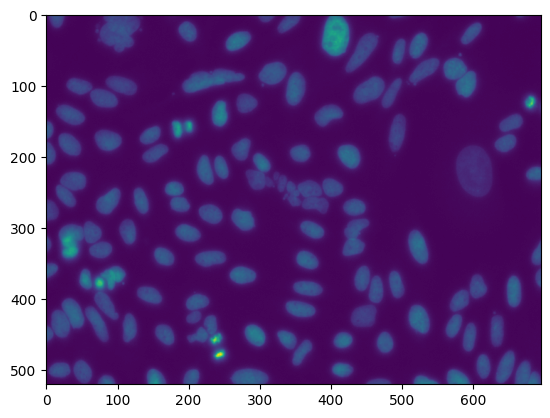

In [19]:
from PIL import Image
import matplotlib.pyplot as plt

# Replace with the correct path to your image file
image_path = '../raw_data/plate_24277/Hoechst/24277-Hoechst/cdp2bioactives_a01_s1_w127df6541-a9a1-46dc-bcdb-b64b187d422b.tif'

# Open the image using PIL
pil_im = Image.open(image_path)

# Convert the image to a NumPy array and display it using matplotlib
plt.imshow(np.asarray(pil_im))


Test if Images are correctly loaded into the image_files and images arrays

In [20]:
# Define the path to the directory containing the extracted images for one channel
channel_dir = os.path.join(base_dir, 'Hoechst/24277-Hoechst')

# Make sure the channel directory is correct
if not os.path.isdir(channel_dir):
    raise ValueError(f"Directory not found: {channel_dir}")

# List all image files in the directory
image_files = [os.path.join(channel_dir, f) for f in os.listdir(channel_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg', '.tif', '.tiff'))]

# Verify that we found image files
if not image_files:
    raise ValueError(f"No image files found in directory: {channel_dir}")

print(f"Found {len(image_files)} image files.")

# Load and preprocess the images
images = []
for img_path in image_files:
    img = load_img(img_path, target_size=(260, 260))  # Resize to the size expected by EfficientNet
    img = img_to_array(img)
    img = preprocess_input(img)  # Preprocess the image
    images.append(img)
images = np.array(images)

# Verify that the images array is not empty
if images.size == 0:
    raise ValueError("The images array is empty. Check if the images are loaded correctly.")



Found 2304 image files.


### Initiating and Running the EfficientNetB3 with the Images

In [21]:
from tensorflow.keras.applications import EfficientNetB3

# Load EfficientNetB3 model pre-trained on ImageNet without the top classification layer
model = EfficientNetB3(weights='imagenet', include_top=False, pooling='avg', input_shape=(260, 260, 3))

# Use the model to extract features
features = model.predict(images)

72/72 [==============================] - 173s 2s/step


In [22]:
features

array([[ 0.1716746 , -0.17619152, -0.23826672, ..., -0.09269767,
        -0.18405038, -0.05733119],
       [ 0.11278784, -0.1738183 , -0.23350216, ..., -0.22353266,
        -0.15091568, -0.02371017],
       [ 0.03226791, -0.16941941, -0.15908942, ..., -0.15237355,
        -0.14053886, -0.08673112],
       ...,
       [-0.03716893, -0.16097137, -0.17480898, ..., -0.1607568 ,
        -0.19898602,  0.0081008 ],
       [ 0.01214301, -0.16492453, -0.14343792, ..., -0.23400144,
        -0.08505377, -0.04745275],
       [ 0.06821415, -0.1621215 , -0.13345382, ..., -0.11092886,
        -0.12427376, -0.0444282 ]], dtype=float32)

In [46]:
type(features)

numpy.ndarray

### KMeans to build Clusters

In [37]:
from sklearn.cluster import KMeans

# Assuming we want to cluster into 5 clusters
n_clusters = 3
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
clusters = kmeans.fit_predict(features)


Testing how each cluster looks by taking the first image in each Cluster

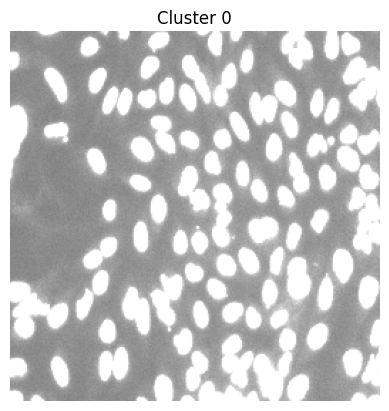

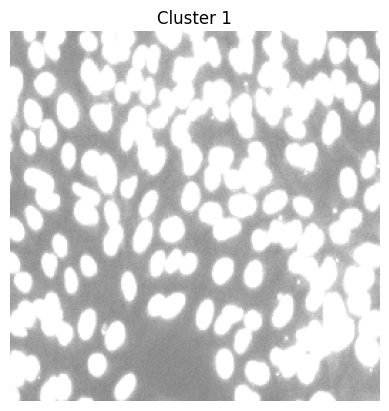

In [29]:
import matplotlib.pyplot as plt

# Create a plot for each cluster
for i in range(n_clusters):
    # Find the images in this cluster
    cluster_indices = np.where(clusters == i)[0]
    representative_idx = cluster_indices[0]  # Take the first image index as representative
    plt.figure()
    plt.imshow(images[representative_idx].astype('uint8'))  # Convert the image back to uint8 format
    plt.title(f'Cluster {i}')
    plt.axis('off')
plt.show()

Change it from grayscale to color and add more images per cluster

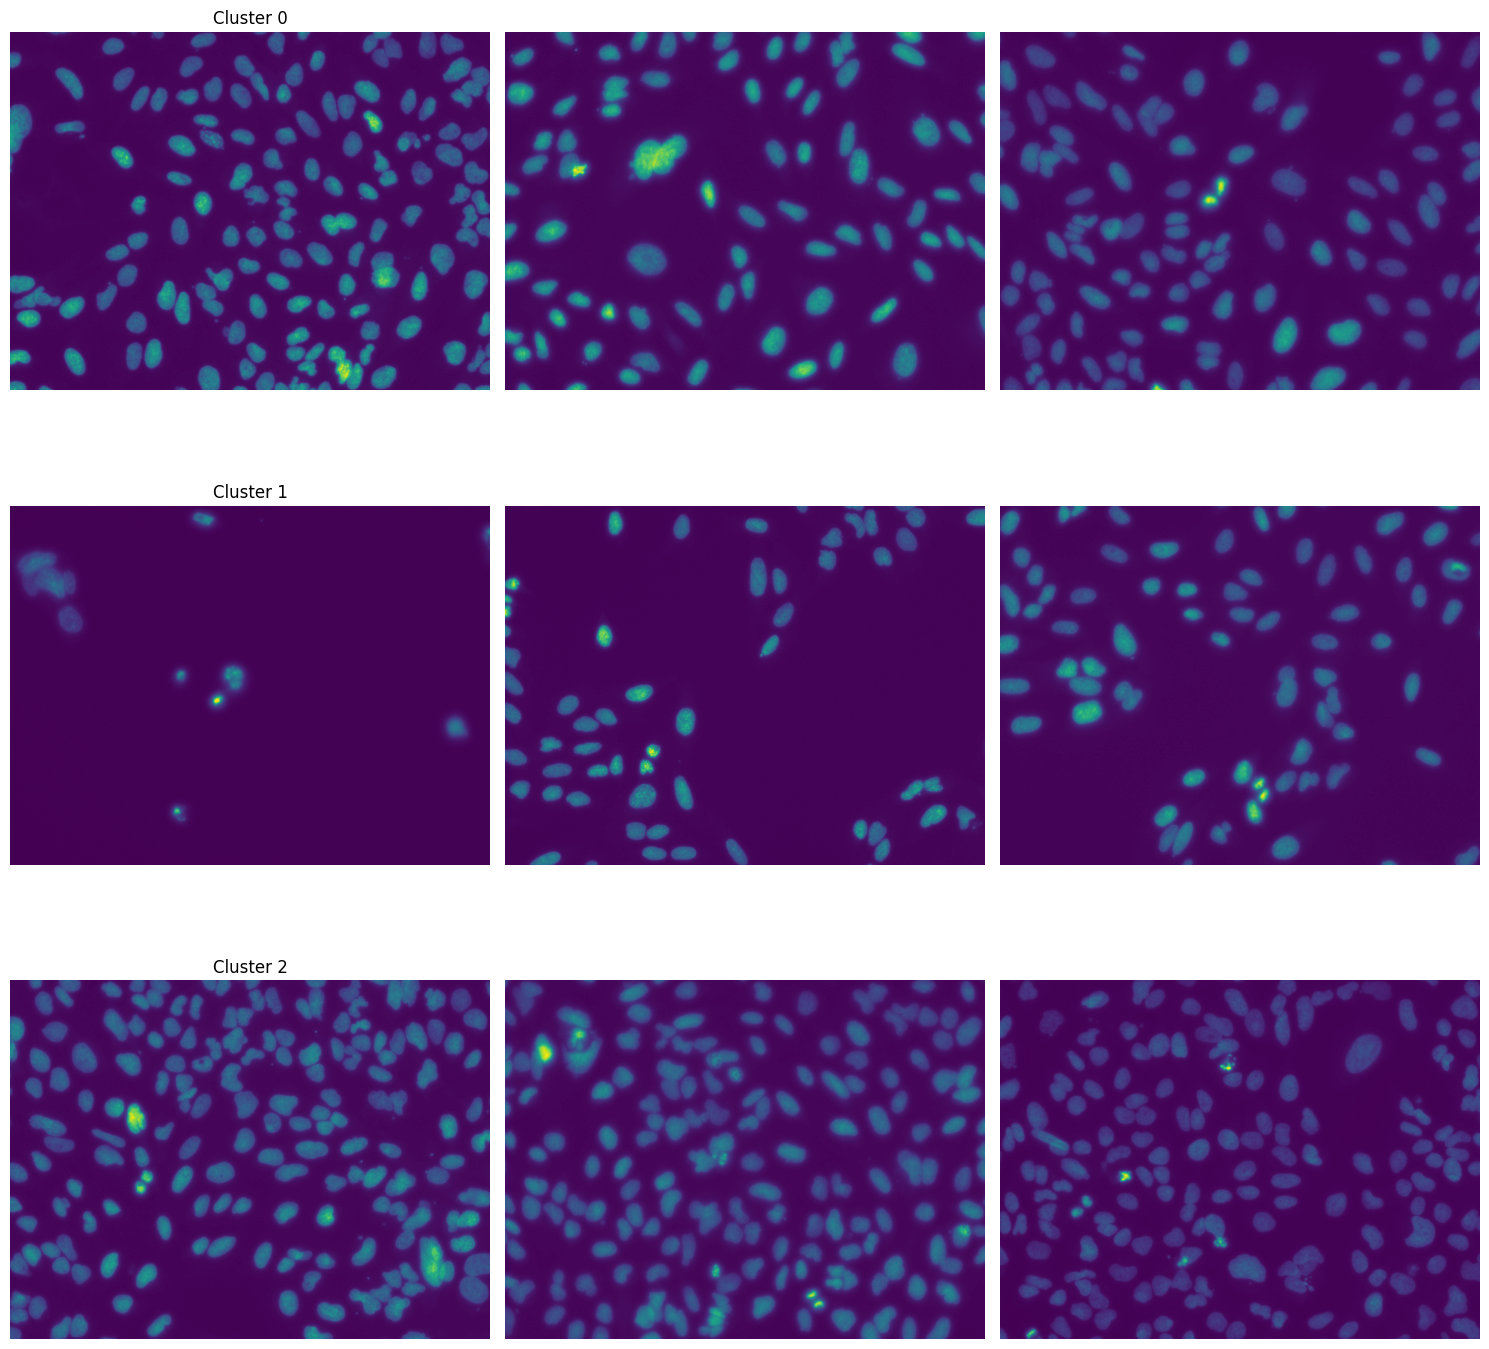

In [39]:
# Define the number of images to display per cluster
num_images_per_cluster = 3

# Create subplots - rows are clusters, columns are images
fig, axs = plt.subplots(n_clusters, num_images_per_cluster, figsize=(5 * num_images_per_cluster, 5 * n_clusters))

for i in range(n_clusters):
    # Get indices of images in this cluster
    indices = np.where(clusters == i)[0]
    # Select a subset of images from the cluster
    selected_indices = indices[:num_images_per_cluster]  # Take the first 'n' images for simplicity

    for j, idx in enumerate(selected_indices):
        # Load and display the image
        img_path = image_files[idx]  # Assuming 'image_files' contains paths of images in the same order as 'features'
        img = Image.open(img_path)
        ax = axs[i, j] if n_clusters > 1 else axs[j]
        ax.imshow(np.asarray(img))
        ax.axis('off')  # Hide the axis
        if j == 0:
            ax.set_title(f'Cluster {i}')

# Adjust layout
plt.tight_layout()
plt.show()


### PCA to display clusters in 2 dimensions

Use the image name as labels and display a few pictures per cluster to compare with components as test

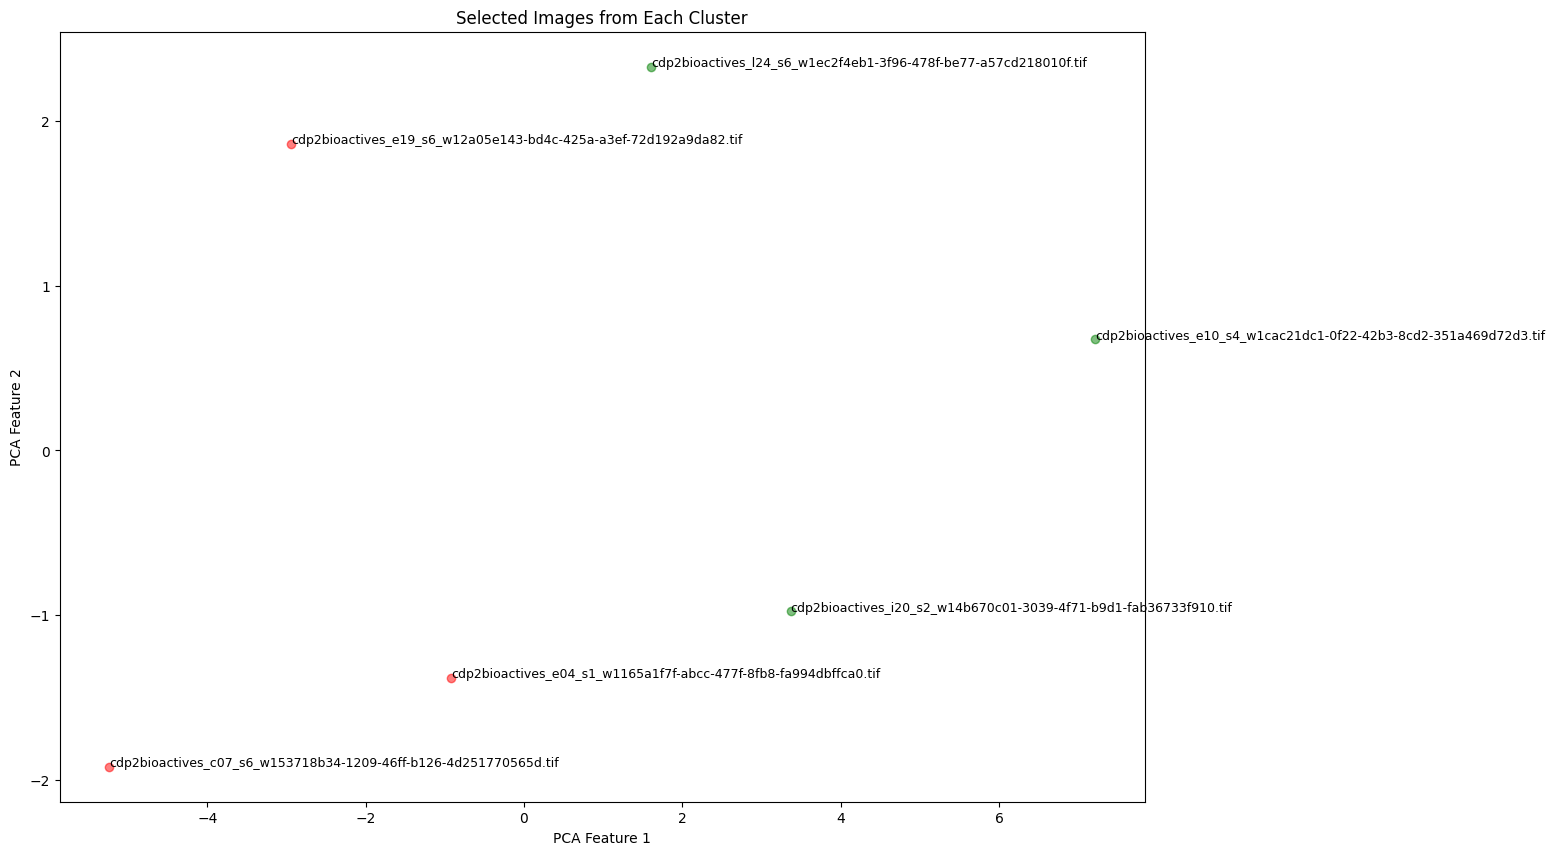

In [35]:
# Reduce the features to two dimensions using PCA for visualization
pca = PCA(n_components=2)
reduced_features = pca.fit_transform(features)

# Assuming 'image_files' corresponds directly to 'features'
# Extract the image filenames
image_names = [os.path.basename(path) for path in image_files]

# Plotting setup
fig, ax = plt.subplots(figsize=(14, 10))

# Different colors for different clusters
colors = ['r', 'g', 'b', 'c', 'm', 'y', 'k']

# Number of images to label per cluster
num_labels_per_cluster = 3

# Collect indices for a few images from each cluster to label
label_indices = []
for cluster in range(kmeans.n_clusters):
    indices_in_cluster = np.where(clusters == cluster)[0]
    selected_indices = np.random.choice(indices_in_cluster, size=min(len(indices_in_cluster), num_labels_per_cluster), replace=False)
    label_indices.extend(selected_indices)

# Plot and annotate selected images
for i in label_indices:
    feature = reduced_features[i]
    cluster = clusters[i]
    ax.scatter(feature[0], feature[1], alpha=0.5, c=colors[cluster % len(colors)])
    image_name = image_names[i]
    ax.text(feature[0], feature[1], image_name, fontsize=9)

# Set title and labels
ax.set_title('Selected Images from Each Cluster')
ax.set_xlabel('PCA Feature 1')
ax.set_ylabel('PCA Feature 2')

plt.show()


Just displaying all clusters without labels in the reduces Feature dimension

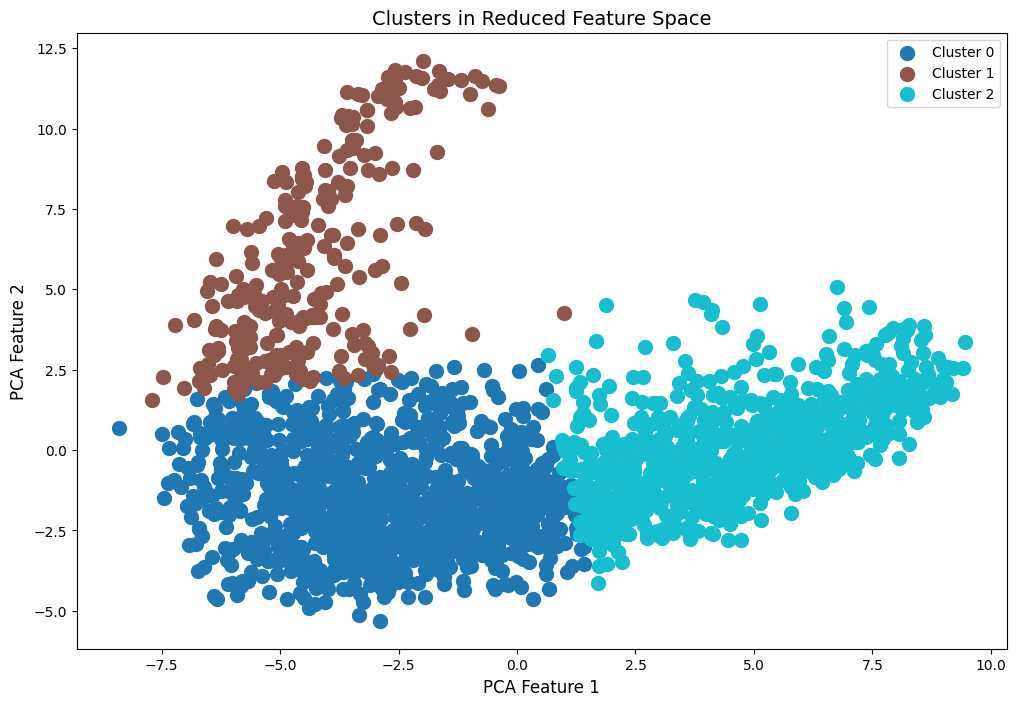

In [38]:
# Use PCA to reduce the feature dimensions to 2 for visualization
pca = PCA(n_components=2)
reduced_features = pca.fit_transform(features)

# Plotting
fig, ax = plt.subplots(figsize=(12, 8))

# Generate a color palette with enough colors
colors = plt.cm.tab10(np.linspace(0, 1, n_clusters))

# Plot each cluster with a different color
for i in range(n_clusters):
    # Select data points that belong to the current cluster
    ix = np.where(clusters == i)
    ax.scatter(reduced_features[ix, 0], reduced_features[ix, 1], c=[colors[i]], label=f'Cluster {i}', s=100)

# Title and labels
ax.set_title('Clusters in Reduced Feature Space', fontsize=14)
ax.set_xlabel('PCA Feature 1', fontsize=12)
ax.set_ylabel('PCA Feature 2', fontsize=12)

# Legend
ax.legend()
plt.show()

Clusters without PCA

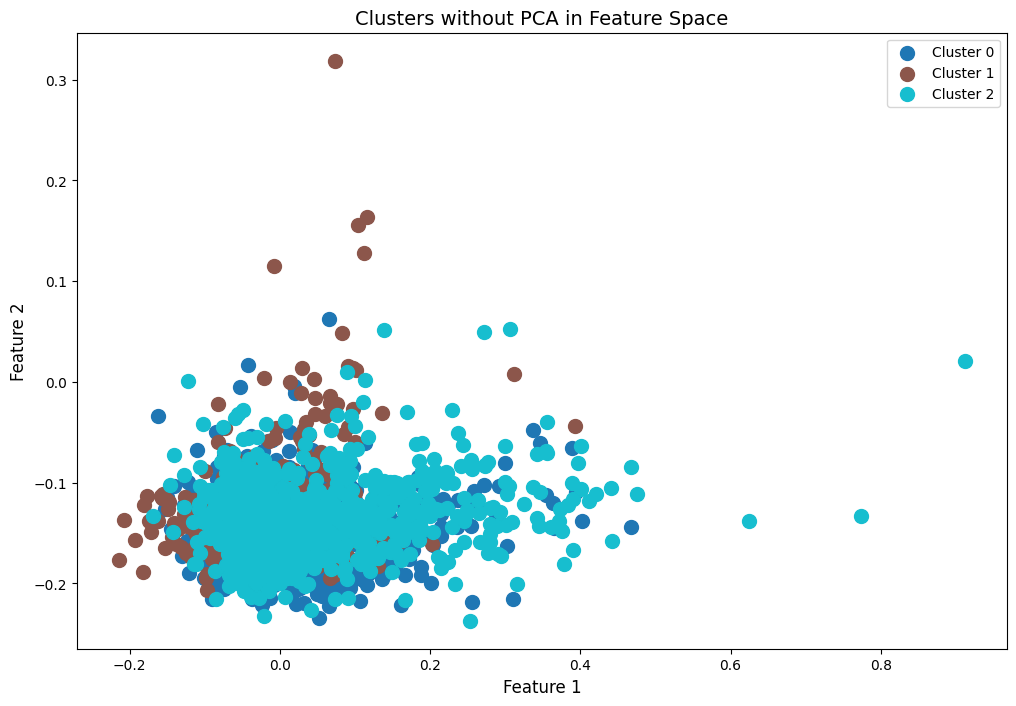

In [45]:
# Plotting
fig, ax = plt.subplots(figsize=(12, 8))

# Generate a color palette with enough colors
colors = plt.cm.tab10(np.linspace(0, 1, n_clusters))

# Plot each cluster with a different color
for i in range(n_clusters):
    # Select data points that belong to the current cluster
    ix = np.where(clusters == i)
    ax.scatter(features[ix, 0], features[ix, 1], c=[colors[i]], label=f'Cluster {i}', s=100)

# Title and labels
ax.set_title('Clusters without PCA in Feature Space', fontsize=14)
ax.set_xlabel('Feature 1', fontsize=12)
ax.set_ylabel('Feature 2', fontsize=12)

# Legend
ax.legend()
plt.show()

In [40]:
# Function to parse well information from filename
def parse_well_from_filename(filename):
    parts = filename.split('_')
    well = parts[1]  # Assuming the well identifier is always in this position
    return well

# Function to combine images
def combine_images(image_paths):
    images = [Image.open(img_path) for img_path in image_paths]
    # Assuming all images are of the same size, concatenate them horizontally (or vertically)
    widths, heights = zip(*(i.size for i in images))
    total_width = sum(widths)
    max_height = max(heights)
    composite = Image.new('RGB', (total_width, max_height))
    x_offset = 0
    for im in images:
        composite.paste(im, (x_offset, 0))
        x_offset += im.size[0]
    return composite

# Assuming 'image_files' contains all image paths
well_to_images = {}
for image_path in image_files:
    well = parse_well_from_filename(os.path.basename(image_path))
    if well not in well_to_images:
        well_to_images[well] = []
    well_to_images[well].append(image_path)

# Combine images for each well into a composite image
composite_images = {well: combine_images(paths) for well, paths in well_to_images.items()}

In [42]:
type(composite_images)


dict

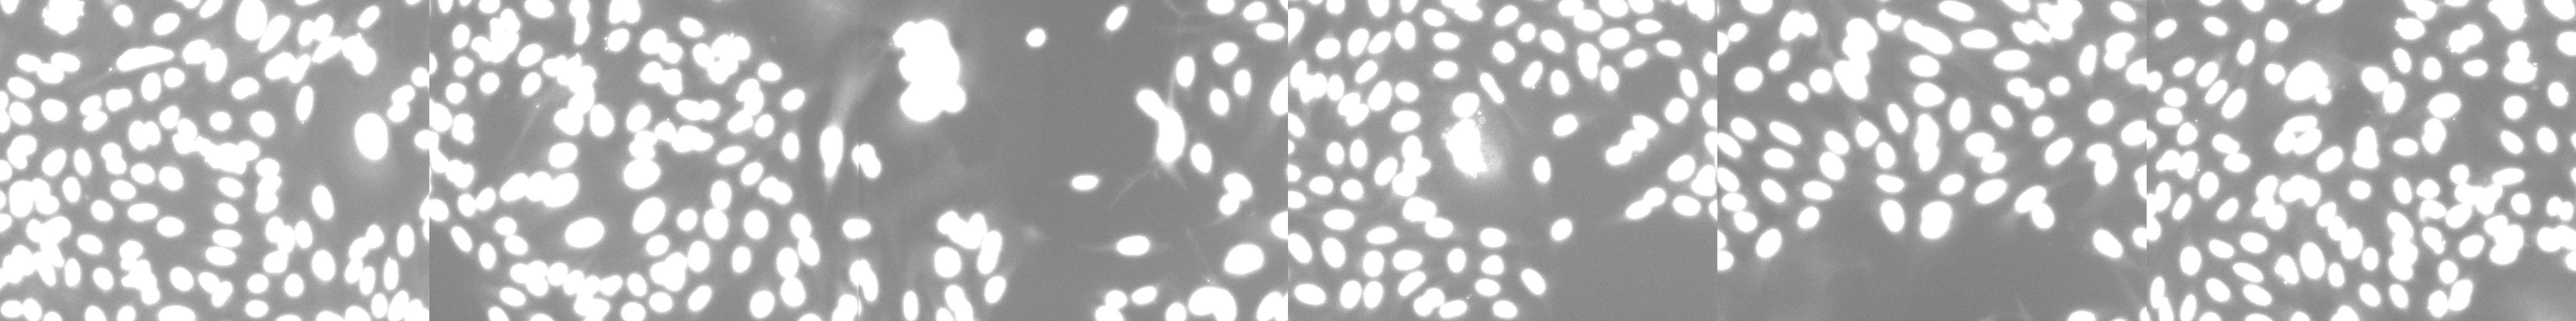

In [43]:
composite_images["a01"]

In [47]:
import cv2
import os

# Your existing code for organizing images by wells
def parse_well_from_filename(filename):
    parts = filename.split('_')
    well = parts[1]  # Assuming the well identifier is always in this position
    return well


well_to_images = {}
for image_path in image_files:
    well = parse_well_from_filename(os.path.basename(image_path))
    if well not in well_to_images:
        well_to_images[well] = []
    well_to_images[well].append(image_path)

# Function to stitch images for a given well
def stitch_images_for_well(image_paths):
    images = [cv2.imread(img_path) for img_path in image_paths]
    stitcher = cv2.Stitcher_create()
    status, stitched_image = stitcher.stitch(images)
    return status, stitched_image

# Loop through each well and perform stitching
composite_images = {}
for well, paths in well_to_images.items():
    status, stitched_image = stitch_images_for_well(paths)
    if status == cv2.Stitcher_OK:
        print(f"Stitching completed successfully for well {well}.")
        composite_images[well] = stitched_image
        # Optionally, save the stitched image to a file
        cv2.imwrite(f'stitched_{well}.jpg', stitched_image)
    else:
        print(f"Stitching failed for well {well}.")

# At this point, 'composite_images' contains the stitched image for each well (if successful)

Stitching failed for well c22.
Stitching failed for well f20.
Stitching failed for well g09.
Stitching failed for well p13.
Stitching failed for well l07.
Stitching failed for well o23.
Stitching failed for well l04.
Stitching failed for well j19.
Stitching failed for well a01.
Stitching failed for well i23.
Stitching failed for well o19.
Stitching failed for well p10.
Stitching failed for well k23.
Stitching failed for well f22.
Stitching failed for well e19.
Stitching failed for well m18.
Stitching failed for well e01.
Stitching failed for well e08.
Stitching failed for well n10.
Stitching failed for well l21.
Stitching failed for well o13.
Stitching failed for well i01.
Stitching failed for well d15.
Stitching failed for well f04.
Stitching failed for well l08.
Stitching failed for well b13.
Stitching failed for well l14.
Stitching failed for well k07.
Stitching failed for well b16.
Stitching failed for well f21.
Stitching failed for well k19.
Stitching failed for well n03.
Stitchin

In [49]:
import cv2
import numpy as np

def estimate_overlap(image1, image2):
    """
    Attempt to find keypoints and matches between two images.
    Returns the number of good matches as a simple overlap estimate.
    """
    # Initialize ORB detector
    orb = cv2.ORB_create()

    # Find the keypoints and descriptors with ORB
    kp1, des1 = orb.detectAndCompute(image1, None)
    kp2, des2 = orb.detectAndCompute(image2, None)

    # Create BFMatcher object
    bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)

    # Match descriptors
    matches = bf.match(des1, des2)

    # Sort them in the order of their distance
    matches = sorted(matches, key=lambda x: x.distance)

    # Assuming good matches have distance less than a threshold (say, 50)
    good_matches = [m for m in matches if m.distance < 50]

    return len(good_matches)

def evaluate_image_quality(image):
    """
    Evaluate the image quality based on sharpness.
    This is a very simple heuristic that might not apply to all images.
    """
    # Convert image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Calculate the Laplacian variance
    laplacian_var = cv2.Laplacian(gray, cv2.CV_64F).var()

    return laplacian_var

# Example usage for a pair of images
image1 = cv2.imread('../raw_data/plate_24277/Hoechst/24277-Hoechst/cdp2bioactives_a01_s1_w127df6541-a9a1-46dc-bcdb-b64b187d422b.tif')
image2 = cv2.imread('../raw_data/plate_24277/Hoechst/24277-Hoechst/cdp2bioactives_a01_s2_w15e4541e6-dfcb-4008-b9f0-7d9154c7dee6.tif')

# Estimate overlap
overlap_estimate = estimate_overlap(image1, image2)
print(f"Estimated overlap (good matches): {overlap_estimate}")

# Evaluate image quality
quality1 = evaluate_image_quality(image1)
quality2 = evaluate_image_quality(image2)
print(f"Image quality estimates (sharpness): {quality1}, {quality2}")

# Adjust Stitcher parameters if necessary and try stitching
stitcher = cv2.Stitcher_create()
stitcher.setPanoConfidenceThresh(0.5)  # Lower this threshold if stitching fails due to low confidence

# Try stitching the images
status, stitched_image = stitcher.stitch([image1, image2])
if status == cv2.Stitcher_OK:
    print("Stitching successful.")
    cv2.imshow('Stitched Image', stitched_image)
    cv2.waitKey(0)
    cv2.destroyAllWindows()
else:
    print("Stitching failed.")

Estimated overlap (good matches): 0
Image quality estimates (sharpness): 0.34716511688985, 0.32120634356932737
Stitching failed.


In [50]:
import cv2

# Function to perform stitching with adjustable parameters
def stitch_images_with_custom_config(image_paths, confidence_threshold):
    # Load images
    images = [cv2.imread(img_path) for img_path in image_paths]

    # Check for successful image loading
    if any(img is None for img in images):
        print("Error loading one or more images.")
        return None

    # Create a Stitcher instance
    stitcher = cv2.Stitcher_create()

    # OpenCV versions prior to 4.5.0 may not support setting PanoConfidenceThresh directly in Python
    # For newer versions, you can try using stitcher.setPanoConfidenceThresh(confidence_threshold)
    # If this method is not available, you may need to adjust source code or explore alternative solutions

    # This is a placeholder for setting the confidence threshold, which might not be directly exposed
    # Check the OpenCV version and documentation for your installation
    # stitcher.setPanoConfidenceThresh(confidence_threshold)

    # Perform stitching
    status, stitched_image = stitcher.stitch(images)

    if status == cv2.Stitcher_OK:
        print("Stitching completed successfully.")
        return stitched_image
    else:
        print(f"Stitching failed with status {status}.")
        return None

# Example usage
image_paths = ['../raw_data/plate_24277/Hoechst/24277-Hoechst/cdp2bioactives_a01_s1_w127df6541-a9a1-46dc-bcdb-b64b187d422b.tif', '../raw_data/plate_24277/Hoechst/24277-Hoechst/cdp2bioactives_a01_s2_w15e4541e6-dfcb-4008-b9f0-7d9154c7dee6.tif']  # Update these paths
confidence_threshold = 0.5  # Adjust this threshold based on experimentation
stitched_image = stitch_images_with_custom_config(image_paths, confidence_threshold)

if stitched_image is not None:
    # Display or save the stitched image
    cv2.imshow('Stitched Image', stitched_image)
    cv2.waitKey(0)
    cv2.destroyAllWindows()
    # cv2.imwrite('path/to/save/stitched_output.jpg', stitched_image)


Stitching failed with status 1.
